### Tensorflow example for MNIST
The goal of this demo is to correctly classify the handwritten digits 0-9.

Each feature in the MNIST dataset is a 784-dim vector, corresponding to the 28 x 28 flattened grayscale pixel image. The pixel intensities are 8-bit unsigned integers, falling into the range [0, 255].

This notebook reshapes a given image to meet the MNIST requirements.
 
Prerequisites on the raw image: 
  * The image must be focused and centered on the number ( a small number with a lot of white space around it will not work )
      * The digit should allready fill at least 80% of the image. <br>
      * 20% or less can be white background arround the image. <br>

In [1]:
%matplotlib inline

import input_data
import cv2
import numpy as np
import math
from scipy import ndimage
from array import array
from tensorflow.python.platform import gfile
import tensorflow as tf
#from IPython.display import display, Image
import matplotlib.pyplot as plt

#### Hyper Parameter

In [2]:
image_file  = "handwritten/3_001.png"
tmp_image_file= "/tmp/singleFileInputImage.png"
save_image_file= "/tmp/singleFileInputImage.png"
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # color range:  0==black and 255==white.

## Plot the test image to be predicted

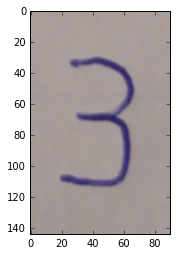

(width, height, channel): (144, 90, 3)


In [3]:
image_data = (ndimage.imread(image_file))
plt.imshow(image_data)
plt.show()
print "(width, height, channel):" , image_data.shape

### There are several things we need to adjust on this image:
<br>
<dl>
    <dt> Color: the MNIST images for training are white digits on a black background </dt>
        <dd>- we currently have blue digets on a gray background </dd>
        <dd>- we currently have 3 color channels (RGB). The MNIST images use only the BINARY channel (black and white) </dd>
    <dt> Shape: the MNIST images for training have a shape of 28x28 </dt>
        <dd>- we currently have a shape of 144x90 </dd>
</dl>

#### How to convert a RGB image into a BINARY (black and white) image :
<br>
<dl>
    <dt>Read the image as a grayscale image</dt>
        <dd>- this step is necessary </dd>
    <dt>Convert it to a binary image by adaptive thresholding or fixed-level thresholding</dt>
        <dd>-  all pixels with a "value > threashold" will become white, and everything else becomes black </dd>
        <dd>-  if you don't want to work out a threshold, you can use the Otsu's method. But this algorithm only works with 8bit images. </dd>
        <dd>-  cv.CV_THRESH_BINARY means every pixel greater than threshold becomes the maxValue (in your case 255), otherwise the value is 0. Obviously if your threshold is 0 everything becomes white (maxValue = 255) and if the value is 255 everything becomes black (i.e. 0).</dd>
</dl>

#### Read the image as a grayscale image

In [4]:
gray = cv2.imread(image_file, cv2.CV_LOAD_IMAGE_GRAYSCALE)

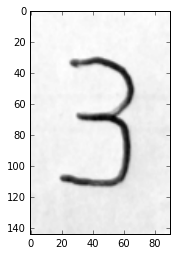

(width, height, channel): (144, 90)


In [5]:
cv2.imwrite(tmp_image_file, gray)
gray = (ndimage.imread(tmp_image_file))
plt.imshow(gray, cmap="gray")
plt.show()
print "(width, height, channel):" , gray.shape

##### Convert it to a binary image by adaptive thresholding or fixed-level thresholding

In [6]:
(thresh, gray) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

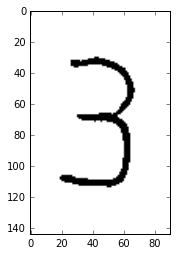

(width, height, channel): (144, 90)


In [7]:
cv2.imwrite(tmp_image_file, gray)
gray = (ndimage.imread(tmp_image_file))
plt.imshow(gray, cmap="gray")
plt.show()
print "(width, height, channel):" , gray.shape

##### Resize the image to 28x28 and invert color

The MNIST images are white digets on black background.

In [8]:
# * Rescale the image to 28 width and 28 height "(image_size, image_size)"
# * Inverse image color (black becomes white, white becomes black) (255.0-gray). 
gray = cv2.resize(pixel_depth-gray, (image_size, image_size))

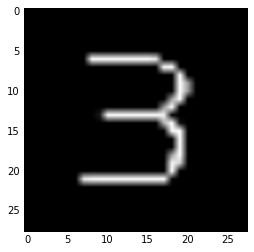

(width, height, channel): (28, 28)


In [9]:
cv2.imwrite(tmp_image_file, gray)
gray = (ndimage.imread(tmp_image_file))
plt.imshow(gray, cmap="gray")
plt.show()
print "(width, height, channel):" , gray.shape

#### Align the digit in the image center and stretch it if needed

In [10]:
# template for 28x28 image box
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)

    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)
    return shiftx,shifty


def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted

In [11]:
while np.sum(gray[0]) == 0:
    gray = gray[1:]

while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)

while np.sum(gray[-1]) == 0:
    gray = gray[:-1]

while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)

rows,cols = gray.shape

if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    # first cols than rows
    gray = cv2.resize(gray, (cols,rows))
else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    # first cols than rows
    gray = cv2.resize(gray, (cols, rows))

colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
(thresh, gray) = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant',constant_values=0)

shiftx,shifty = getBestShift(gray)
shifted = shift(gray,shiftx,shifty)
gray = shifted

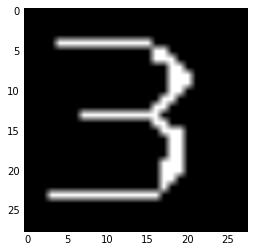

(width, height, channel): (28, 28)


In [12]:
cv2.imwrite(tmp_image_file, gray)
gray = (ndimage.imread(tmp_image_file))
plt.imshow(gray, cmap="gray")
plt.show()
print "(width, height, channel):" , gray.shape

In [13]:
cv2.imwrite(save_image_file, gray)

True